In [1]:
import sys
from collections import defaultdict

import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import numpy as np
from PIL import Image, ImageDraw

import torch

sys.path.append(r"../")
from AssistanceTransform import transform

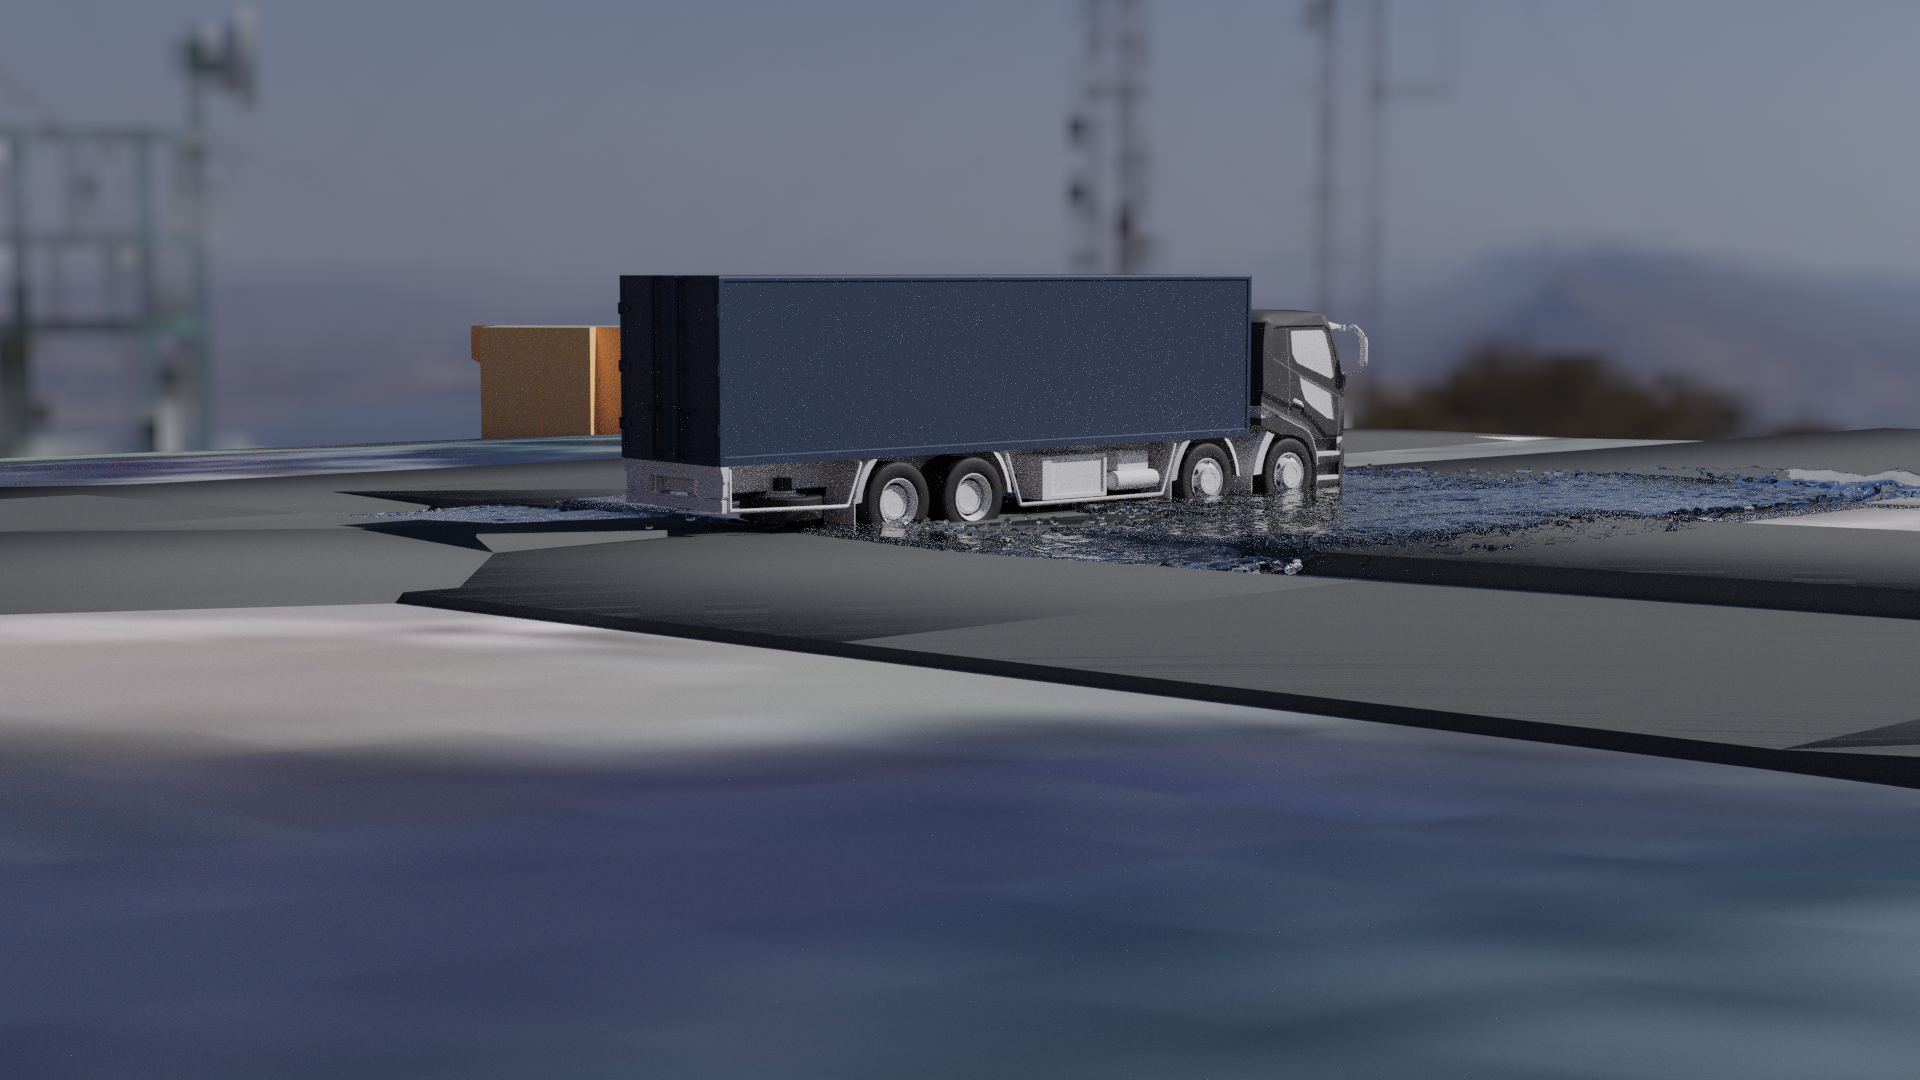

In [2]:
# Relative to my machine, not in Github!
# img_path = r"D:..\..\notes\img\real.jpg"
# img_path = r"D:..\..\jonasdata\fluid_res_310\images\render_0.png"
# img_path = r"D:..\..\notes\img\tb-2018-inbeeld-152.jpg"
img_path = r"..\notebooks\data\trucks\render_0.png"

img = Image.open(img_path)
img

In [3]:
def load_model(model_url="COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml", threshold=0.7, return_cfg=False):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_url))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_url)
    predictor = DefaultPredictor(cfg)
    if return_cfg:
        return predictor, cfg
    else:
        return predictor
    
predictor, cfg = load_model(return_cfg=True)

In [4]:
preds = predictor(np.asarray(img)[...,:3])  # Detectron2 expects 3D array, e.g. .PNG is 4D
preds

C:\Users\Caspe\Anaconda3\envs\AssistanceTransform\lib\site-packages\detectron2\layers\wrappers.py:240: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  return x.nonzero().unbind(1)


{'instances': Instances(num_instances=1, image_height=1080, image_width=1920, fields=[pred_boxes: Boxes(tensor([[ 619.6533,  272.9692, 1355.1964,  532.9693]], device='cuda:0')), scores: tensor([0.9633], device='cuda:0'), pred_classes: tensor([7], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]], device='cuda:0')])}

In [5]:
def instances_to_dict(preds, thing_classes):
    class_dict = defaultdict(list)
    ins = preds["instances"]
    masks = ins.get("pred_masks")
    classes = ins.get("pred_classes")
    for i in range(len(ins)):
        class_int = classes[i].item()
        class_str = thing_classes[class_int]
        mask = masks[i]
        class_dict[class_str].append(mask)
    return class_dict

d = instances_to_dict(preds, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).get("thing_classes"))

In [6]:
def get_heads_feet(mask: torch.tensor, step_size=5, min_size=0.9):
    head, feet = [], []
    # Get all points where point == 1 (mask)
    mask_points = mask.nonzero()
    # For each unique value for the x-plane
    for x in torch.unique(mask_points[...,1]):
        # Get the indices at which mask[:, x] == x
        index = (mask_points.T[1] == x).nonzero()
        # Get all values for y where mask[:, x] == x
        ys = mask_points[index, 0]
        # Get max and min y, cast to CPU
        max_y, min_y = ys.max().item(), ys.min().item()
        # Remove max_y == min_y
        if max_y != min_y:
            # Cast x to CPU
            x = x.item()
            head.append([x, max_y])
            feet.append([x, min_y])
    # Turn head, feet into a numpy array and reverse
    reference = np.array([head, feet])[::-1]
    min_dist = min_size * np.max(reference[1] - reference[0])
    # Remove those that are outside the minimum threshold
    reference = reference[:, (reference[1] - reference[0])[:,1] >= min_dist]
    
    # Apply step size
    return reference[:, 0::step_size]

# reference = get_heads_feet(d.get("truck")[0], step_size=5)

In [7]:
def extract_reference(objects: dict, step_size=10, min_size=0.9):
    args = []
    for key, masks in objects.items():
        refs = [get_heads_feet(mask, step_size=step_size, min_size=min_size) for mask in masks]
        refs = np.concatenate(refs, axis=1)
        height = 3.9  # FIXME placeholder
        STD = 0.1  # FIXME placeholder
        args.append((refs, height, STD))
    return args

args = extract_reference(d)

In [8]:
# cam.getTopViewOfImage(np.asarray(img))

In [9]:
img = Image.open(img_path)
draw = ImageDraw.Draw(img)
for arg in args:
    reference = arg[0]
    min_ = (0.8 * np.max(reference[1] - reference[0]))
    for i in range(reference.shape[1]):
        heads, feet = reference[:, i]
#         print((feet - heads)[1])
        if (feet - heads)[1] >= min_ or True:
#             print(heads, feet, feet-heads)

    #         draw.point(heads, fill="red")
    #         draw.point(feet, fill="yellow")
            draw.line([(*heads), (*feet)], fill="yellow", width=2)
        else:
            print("scream")
            continue
img.show()

In [10]:
# img.show()

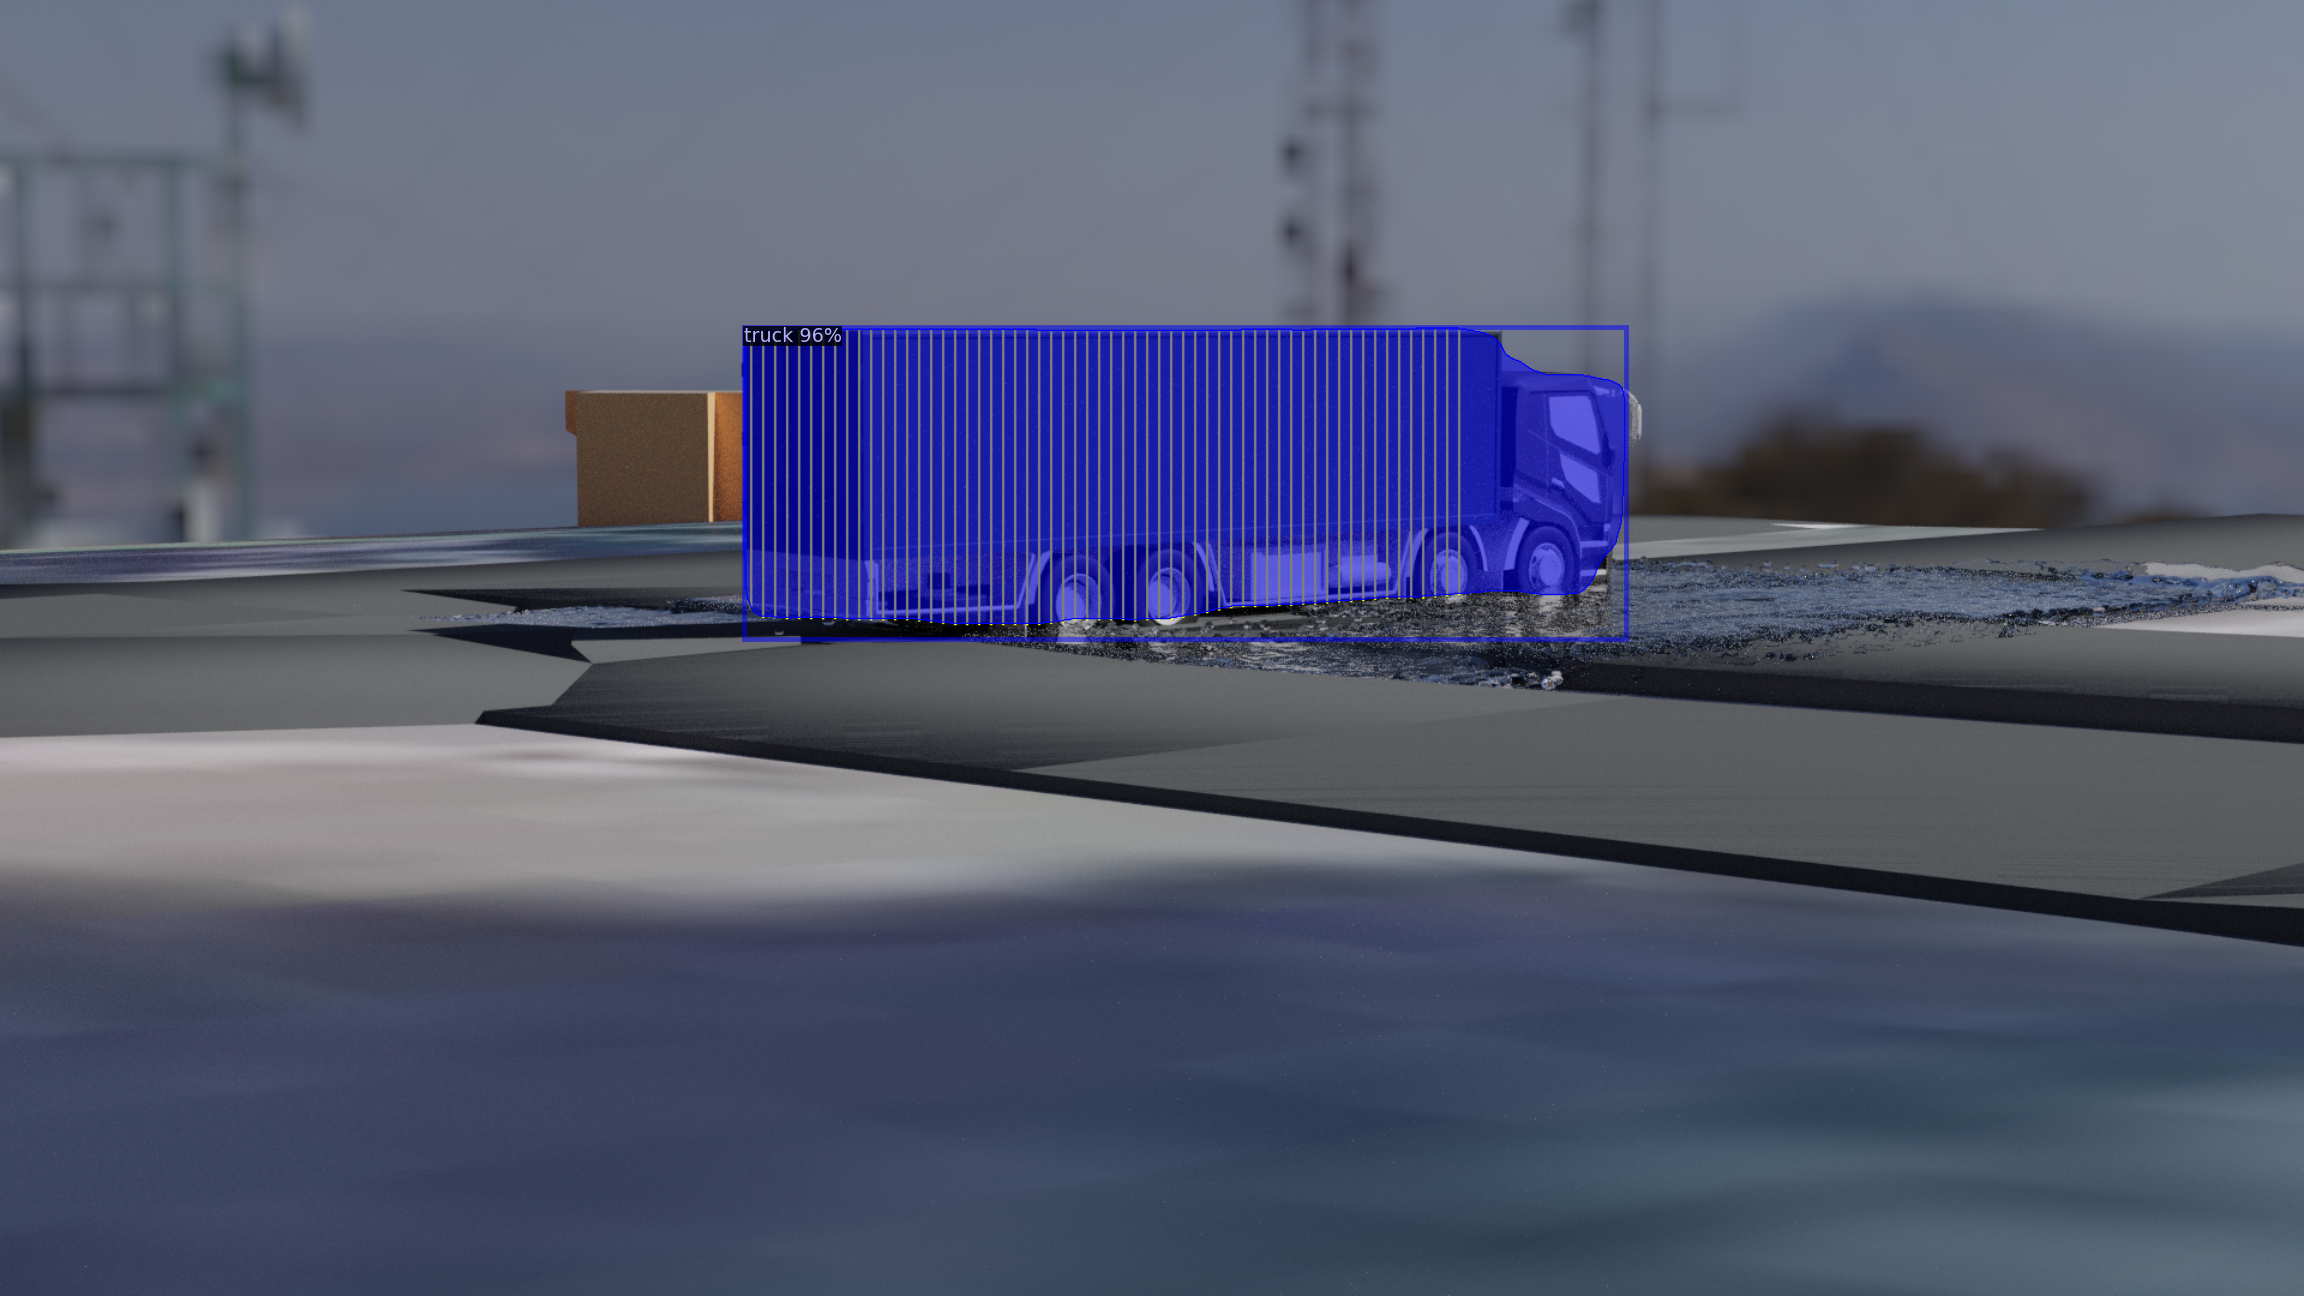

In [11]:
v = Visualizer(np.asarray(img)[...,:3][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(preds["instances"].to("cpu"))
Image.fromarray(out.get_image()[:, :, ::-1])

Predicted

In [12]:
arg = args[0]

In [13]:
cam = transform.fit(img=img, reference=arg[0], height=arg[1], STD=arg[2], meta_data={"focal_length":50.0, "sensor_size": (24.0, 36.0), "image_size": (1920, 1080)}, iters=1e4)
params = cam.orientation.parameters
params = np.array((params.roll_deg, params.tilt_deg, params.heading_deg, params.elevation_m))
params

array([ -0.20933177,  86.2635203 , -71.53702889,   3.83975832])

Real

In [14]:
# Real:
real = np.array((0, 84.16779448324309, 47.19223369280777, 11.382741928100586 - 4.030753135681152))
real

array([ 0.        , 84.16779448, 47.19223369,  7.35198879])

Distance

In [15]:
(params - real)

array([  -0.20933177,    2.09572581, -118.72926259,   -3.51223047])